# **1. SỬ DỤNG MÔ HÌNH CNN**

# Import các thư viện cần thiết 

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import concurrent.futures
import multiprocessing
from tensorflow.keras.preprocessing.image import array_to_img
import gc

2025-04-21 12:21:54.163847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745238114.405676      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745238114.477590      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: ml-dtypes
    Found existing ins

In [3]:
!pip install nvidia-pyindex nvidia-cuda-runtime-cu12 nvidia-cudnn-cu12

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-pyindex: filename=nvidia_pyindex-1.0.9-py3-none-any.whl size=8419 sha256=eb0490fc54bb47b4697c80d68f26fecd8e2f0cdf389abe113f23df4ccc6c5e9e
  Stored in directory: /root/.cache/pip/wheels/49/d0/7d/b68b3665d16ee20355e65fb7ef48b7ca26533217d9f09924fe
Successfully built nvidia-pyindex


# Kiểm tra GPU

In [4]:
print("Số GPU khả dụng:", len(tf.config.list_physical_devices('GPU')))
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
print("Số lõi CPU:", multiprocessing.cpu_count())

Số GPU khả dụng: 2
Số lõi CPU: 4


# DataFrame, resize ảnh

In [5]:
def create_dataframe(data_dir):
    data = [
        {"image_path": os.path.join(data_dir, cls_name, fname), "label": idx}
        for idx, cls_name in enumerate(os.listdir(data_dir))
        for fname in os.listdir(os.path.join(data_dir, cls_name))
    ]
    return pd.DataFrame(data)


# Hàm resize ảnh
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((128, 128)))

# Hàm vẽ biểu đồ

In [6]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['accuracy'], label='Acc Huấn luyện')
    ax1.plot(history.history['val_accuracy'], label='Acc Kiểm tra')
    ax1.set_title('Độ chính xác'); ax1.legend(); ax1.grid(True)
    ax2.plot(history.history['loss'], label='Loss Huấn luyện')
    ax2.plot(history.history['val_loss'], label='Loss Kiểm tra')
    ax2.set_title('Hàm mất mát'); ax2.legend(); ax2.grid(True)
    plt.savefig('/kaggle/working/training_history.png')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Dự đoán'); plt.ylabel('Thực tế'); plt.title('Ma trận nhầm lẫn')
    plt.savefig('/kaggle/working/confusion_matrix.png')
    plt.show()

def plot_data_distribution(class_counts, label_map):
    plt.figure(figsize=(12,6))
    plt.bar(list(label_map.values()), class_counts)
    plt.xticks(rotation=45, ha='right')
    plt.title('Phân bố số lượng ảnh theo lớp')
    plt.ylabel('Số ảnh')
    plt.savefig('/kaggle/working/data_distribution.png')
    plt.show()

def plot_sample_images(df, label_map, num_samples=9):
    plt.figure(figsize=(12,12))
    for i, cls in enumerate(df['label'].unique()[:num_samples]):
        sample = df[df['label']==cls].sample(1).iloc[0]
        plt.subplot(3,3,i+1)
        plt.imshow(sample['image'])
        plt.title(label_map[cls]); plt.axis('off')
    plt.tight_layout()
    plt.savefig('/kaggle/working/sample_images.png')
    plt.show()

def plot_roc_curves(y_test, y_pred_proba, num_classes, label_map):
    plt.figure(figsize=(12,10))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred_proba[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f"{label_map[i]} (AUC={roc_auc[i]:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('Tỉ lệ dương tính giả'); plt.ylabel('Tỉ lệ dương tính đúng')
    plt.title('Đường cong ROC'); plt.legend(loc='lower right')
    plt.savefig('/kaggle/working/roc_curves.png')
    plt.show()
    return np.mean(list(roc_auc.values()))

# Hàm tạo & huấn luyện mô hình

In [7]:
def create_and_train_model(X_train, y_train, X_val, y_val, input_shape, num_classes, epochs=25):
    # Tạo Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train)

    # Xây dựng mô hình
    inp = Input(shape=input_shape)
    base = DenseNet201(include_top=False, weights='imagenet', input_tensor=inp)
    x = Flatten()(base.output)
    x = Dropout(0.7)(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    opt = SGD(learning_rate=1e-3, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Tính class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))
    class_weight_dict = dict(enumerate(class_weights))

    # Callbacks
    lr_red = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=1e-5, verbose=1)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    # Huấn luyện mô hình
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[lr_red, early_stopping],
        class_weight=class_weight_dict
    )
    return model, history

# Nạp & resize toàn bộ ảnh

##  Đường dẫn

In [8]:
train_dir = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_dir  = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test'
max_per_class = 2000

## Tạo DataFrame 

In [9]:
df_train = create_dataframe(train_dir)
df_test = create_dataframe(test_dir)
df = pd.concat([df_train, df_test], ignore_index=True)

## Tạo label_map 

In [10]:
label_map = {i: cls for i, cls in enumerate(os.listdir(train_dir))}
num_classes = len(label_map)
print("Label map:", label_map)

Label map: {0: 'pigmented benign keratosis', 1: 'melanoma', 2: 'vascular lesion', 3: 'actinic keratosis', 4: 'squamous cell carcinoma', 5: 'basal cell carcinoma', 6: 'seborrheic keratosis', 7: 'dermatofibroma', 8: 'nevus'}


## Giới hạn mỗi lớp

In [11]:
df = df.groupby('label').head(max_per_class).reset_index(drop=True)

## Resize song song

In [12]:
with concurrent.futures.ThreadPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
    df['image'] = list(executor.map(resize_image_array, df['image_path']))

## Loại bỏ các ảnh lỗi

In [13]:
df = df.dropna(subset=['image']).reset_index(drop=True)

## Chia dữ liệu

In [14]:
X = np.stack(df['image'].values)
y = to_categorical(df['label'].values, num_classes=num_classes)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Data Augmentation

In [15]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.5,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment để cân bằng lớp
aug_df = pd.DataFrame(columns=['image_path', 'label', 'image'])
for lbl in df['label'].unique():
    cls_df = df[df['label'] == lbl]
    aug_df = pd.concat([aug_df, cls_df], ignore_index=True)
    n_need = max_per_class - len(cls_df)
    if n_need > 0:
        imgs = cls_df['image'].values
        sel = np.random.choice(imgs, n_need, replace=True)
        for img in sel:
            batch = np.expand_dims(img, 0)
            aug_iter = datagen.flow(batch, batch_size=1)
            aug = aug_iter.__next__()[0].astype('uint8')  # Sử dụng __next__() thay vì next()
            new_row = pd.DataFrame([{'image_path': None, 'label': lbl, 'image': aug}])
            aug_df = pd.concat([aug_df, new_row], ignore_index=True)  # Sử dụng pd.concat() thay vì append()

# Cân bằng và shuffle
df = aug_df.groupby('label').head(max_per_class).sample(frac=1, random_state=42).reset_index(drop=True)

# Tóm tắt & trực quan dữ liệu

pigmented benign keratosis    : 2000
melanoma                      : 2000
vascular lesion               : 2000
actinic keratosis             : 2000
squamous cell carcinoma       : 2000
basal cell carcinoma          : 2000
seborrheic keratosis          : 2000
dermatofibroma                : 2000
nevus                         : 2000


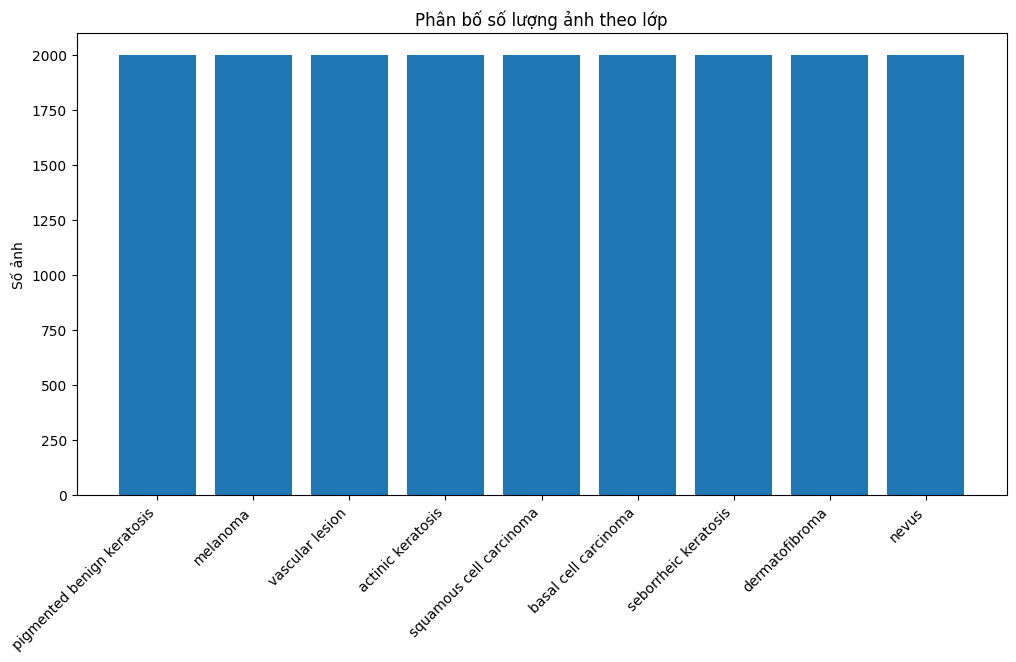

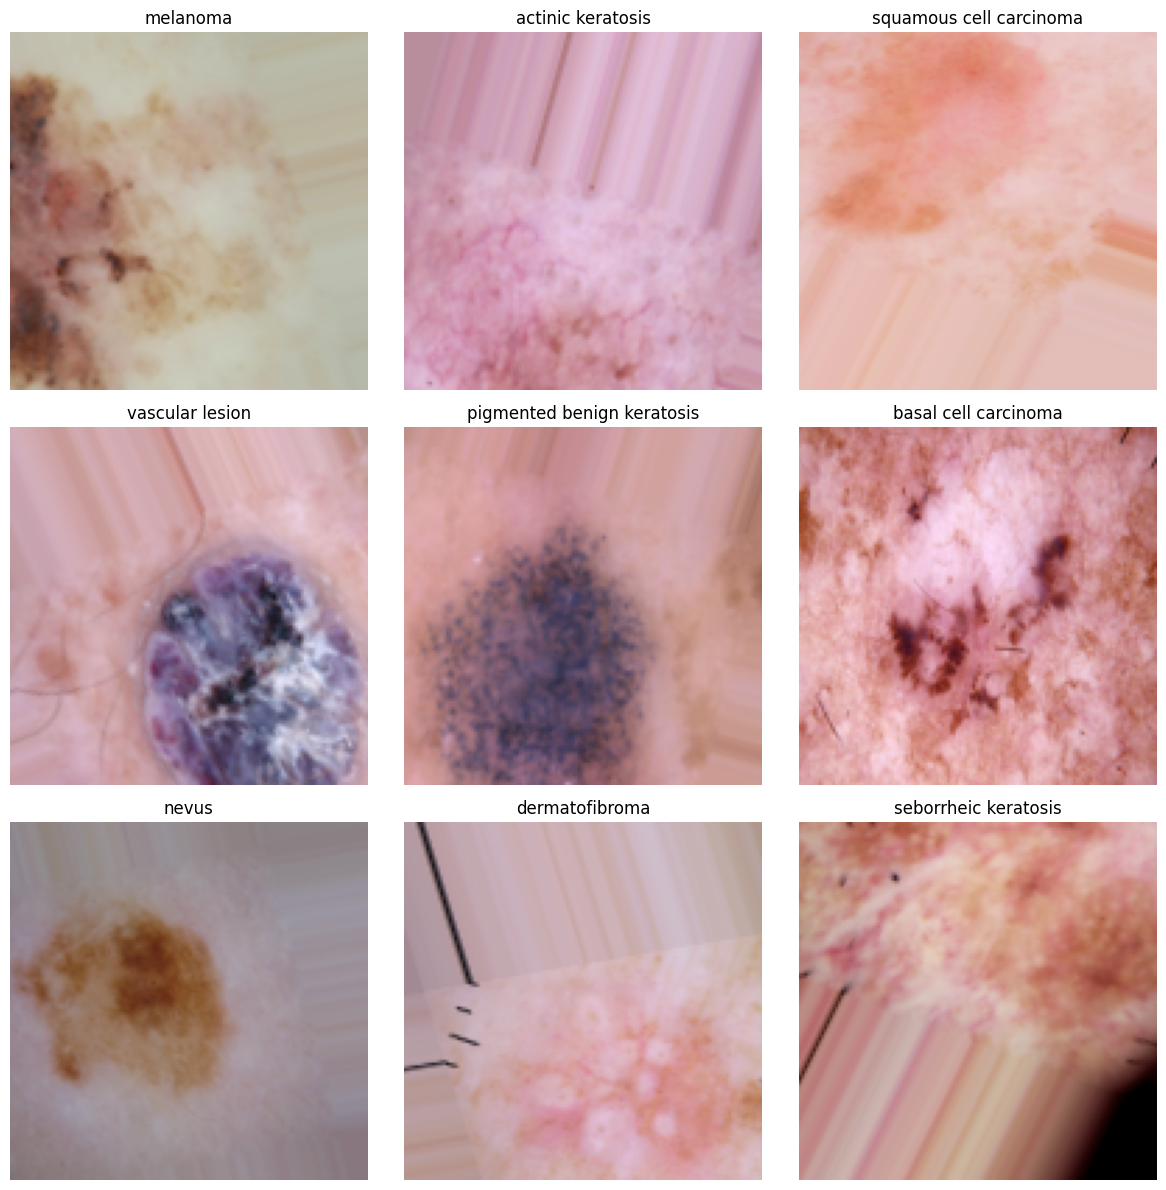

In [16]:
counts = df['label'].value_counts().sort_index()
for i,name in label_map.items():
    print(f"{name:<30}: {counts[i]}")
plot_data_distribution(counts, label_map)
plot_sample_images(df, label_map)


# Chuẩn bị train/val/test

In [17]:
X = np.stack(df['image'].values)  # (N,128,128,3)
y = df['label'].values

# Chuẩn hóa
mean, std = X.mean(), X.std()
X = (X - mean) / std

# One-hot
y_cat = tf.keras.utils.to_categorical(y, num_classes)

# Chia tập
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


Shapes: (11520, 128, 128, 3) (2880, 128, 128, 3) (3600, 128, 128, 3)


## Giải phóng bộ nhớ

In [18]:
df = df.drop(columns=['image', 'image_path'])
X = None
y = None
gc.collect()

20825

# Huấn luyện mô hình

I0000 00:00:1745238317.950678      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745238317.951465      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
I0000 00:00:1745238424.151757      98 service.cc:148] XLA service 0x7d7c9c004990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745238424.152672      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745238424.152680      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745238432.209569      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745238618.198889      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


360/360 ━━━━━━━━━━━━━━━━━━━━ 377s 236ms/step - accuracy: 0.2838 - loss: 7.2990 - val_accuracy: 0.5639 - val_loss: 5.7583 - learning_rate: 0.0010
Epoch 2/25
360/360 ━━━━━━━━━━━━━━━━━━━━ 63s 171ms/step - accuracy: 0.5271 - loss: 5.6920 - val_accuracy: 0.6639 - val_loss: 4.8570 - learning_rate: 0.0010
Epoch 3/25
360/360 ━━━━━━━━━━━━━━━━━━━━ 63s 172ms/step - accuracy: 0.6153 - loss: 4.8892 - val_accuracy: 0.7149 - val_loss: 4.2134 - learning_rate: 0.0010
Epoch 4/25
360/360 ━━━━━━━━━━━━━━━━━━━━ 63s 171ms/step - accuracy: 0.6625 - loss: 4.2677 - val_accuracy: 0.7097 - val_loss: 3.7691 - learning_rate: 0.0010
Epoch 5/25
360/360 ━━━━━━━━━━━━━━━━━━━━ 63s 173ms/step - accuracy: 0.7137 - loss: 3.7138 - val_accuracy: 0.7674 - val_loss: 3.2584 - learning_rate: 0.0010
Epoch 6/25
360/360 ━━━━━━━━━━━━━━━━━━━━ 64s 174ms/step - accuracy: 0.7415 - loss: 3.2661 - val_accuracy: 0.8021 - val_loss: 2.8225 - learning_rate: 0.0010
Epoch 7/25
360/360 ━━━━━━━━━━━━━━━━━━━━ 63s 173ms/step - accuracy: 0.7641 - loss

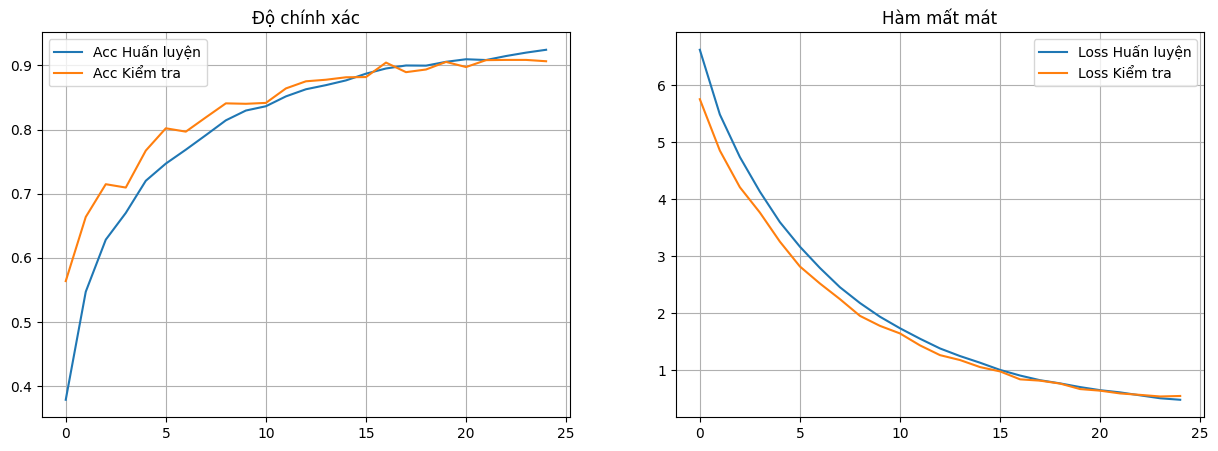

In [19]:
input_shape = (128, 128, 3)
model, history = create_and_train_model(
    X_train, y_train, X_val, y_val,
    input_shape, num_classes, epochs=25
)
plot_training_history(history)


# Đánh giá trên tập Test

113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 277ms/step


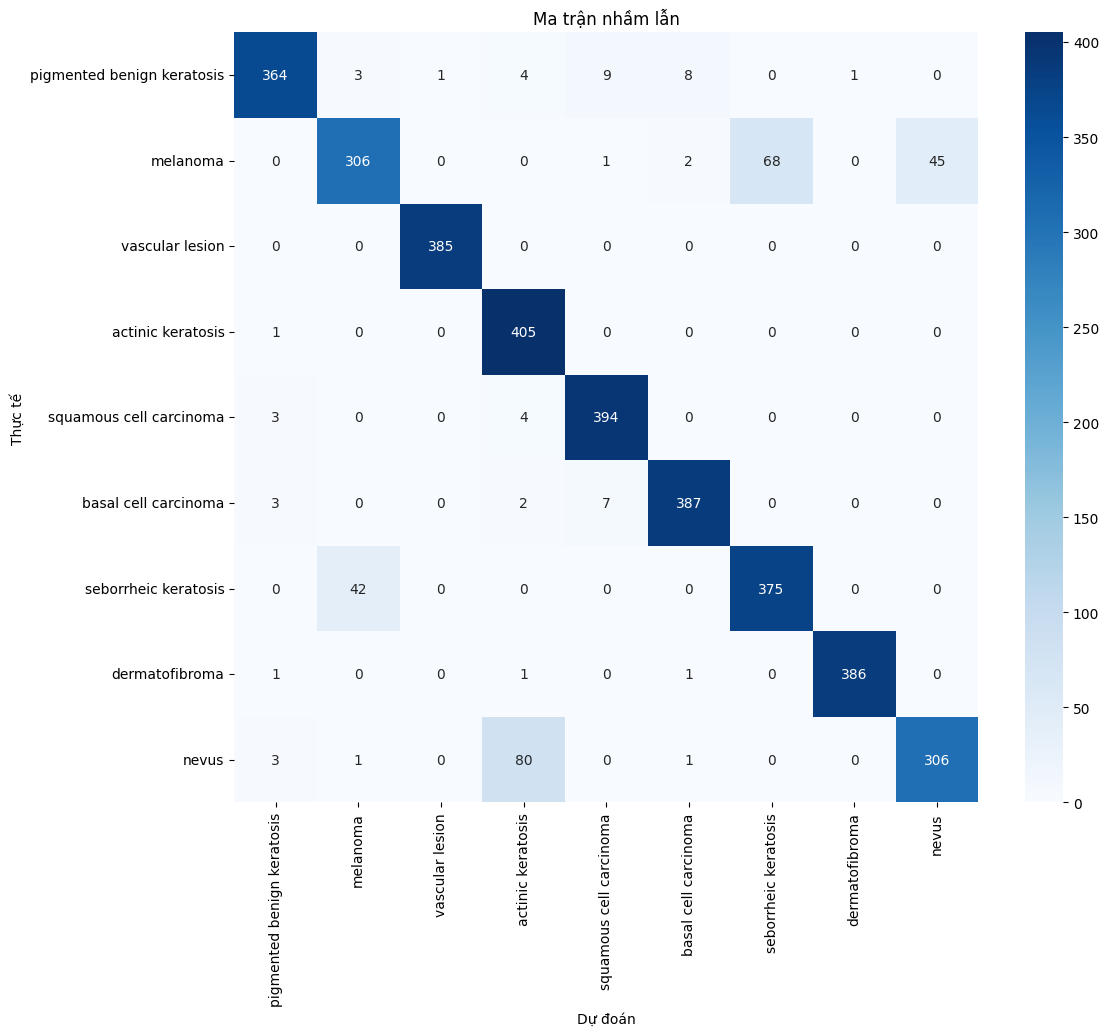

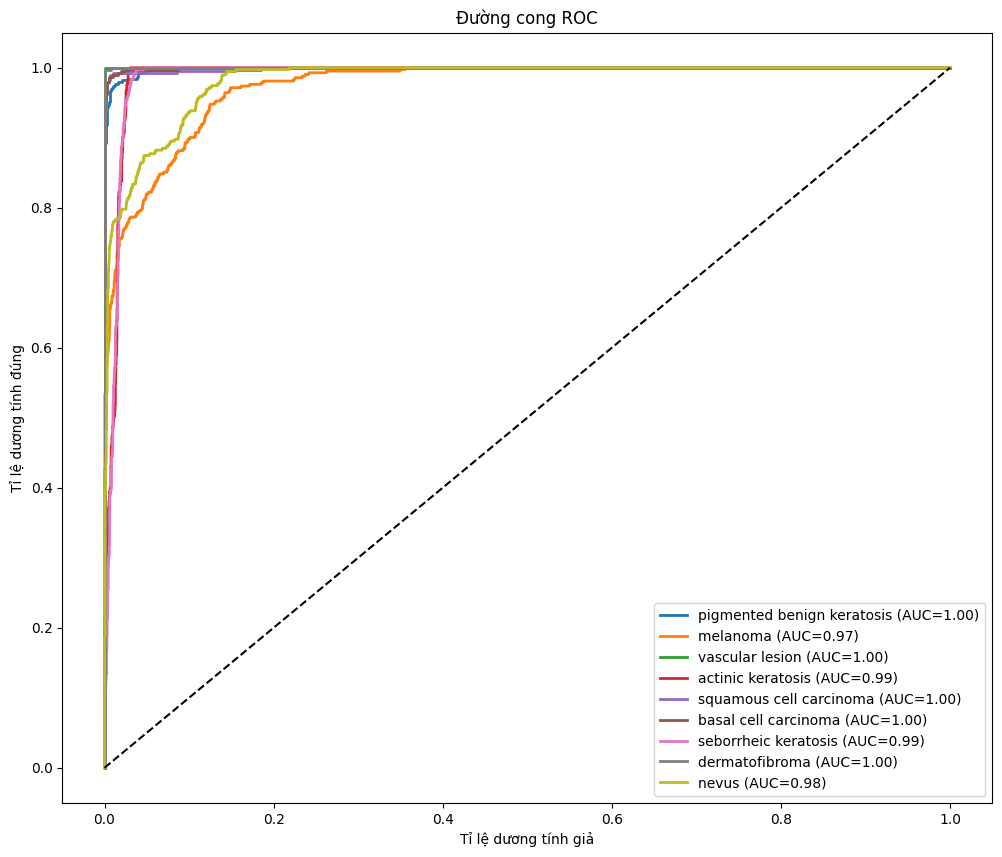

Mean AUC: 0.99
                            precision    recall  f1-score   support

pigmented benign keratosis       0.97      0.93      0.95       390
                  melanoma       0.87      0.73      0.79       422
           vascular lesion       1.00      1.00      1.00       385
         actinic keratosis       0.82      1.00      0.90       406
   squamous cell carcinoma       0.96      0.98      0.97       401
      basal cell carcinoma       0.97      0.97      0.97       399
      seborrheic keratosis       0.85      0.90      0.87       417
            dermatofibroma       1.00      0.99      0.99       389
                     nevus       0.87      0.78      0.82       391

                  accuracy                           0.92      3600
                 macro avg       0.92      0.92      0.92      3600
              weighted avg       0.92      0.92      0.92      3600



In [20]:
# Đánh giá mô hình
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Vẽ ma trận nhầm lẫn
plot_confusion_matrix(y_test_classes, y_pred_classes, list(label_map.values()))

# Vẽ đường cong ROC
mean_auc = plot_roc_curves(y_test, y_pred, num_classes, label_map)
print(f"Mean AUC: {mean_auc:.2f}")

# Báo cáo phân loại
print(classification_report(y_test_classes, y_pred_classes, target_names=list(label_map.values())))

# Vẽ đường cong Precision–Recall cho từng lớp

In [21]:
y_pred_proba = model.predict(X_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step


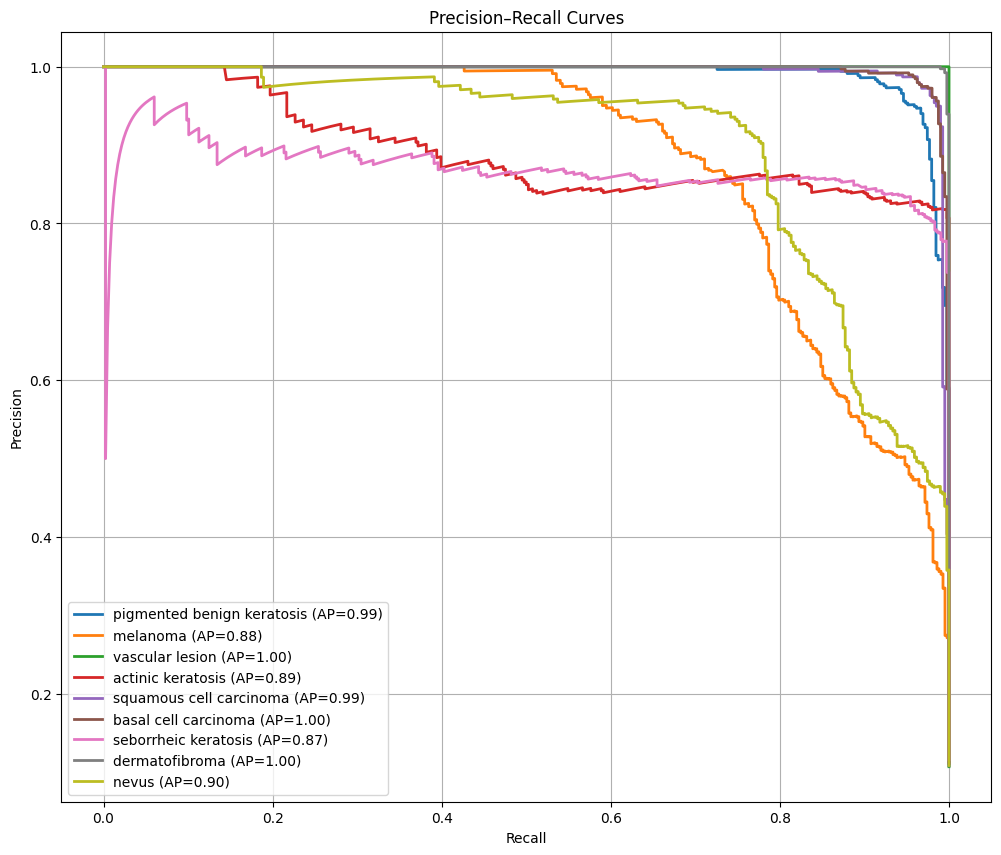

In [22]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(12,10))
for i in range(num_classes):
    prec, rec, _ = precision_recall_curve(y_test[:, i], y_pred_proba[:, i])
    plt.plot(rec, prec, lw=2,
             label=f"{label_map[i]} (AP={auc(rec, prec):.2f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Lưu mô hình & dự đoán một số mẫu

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


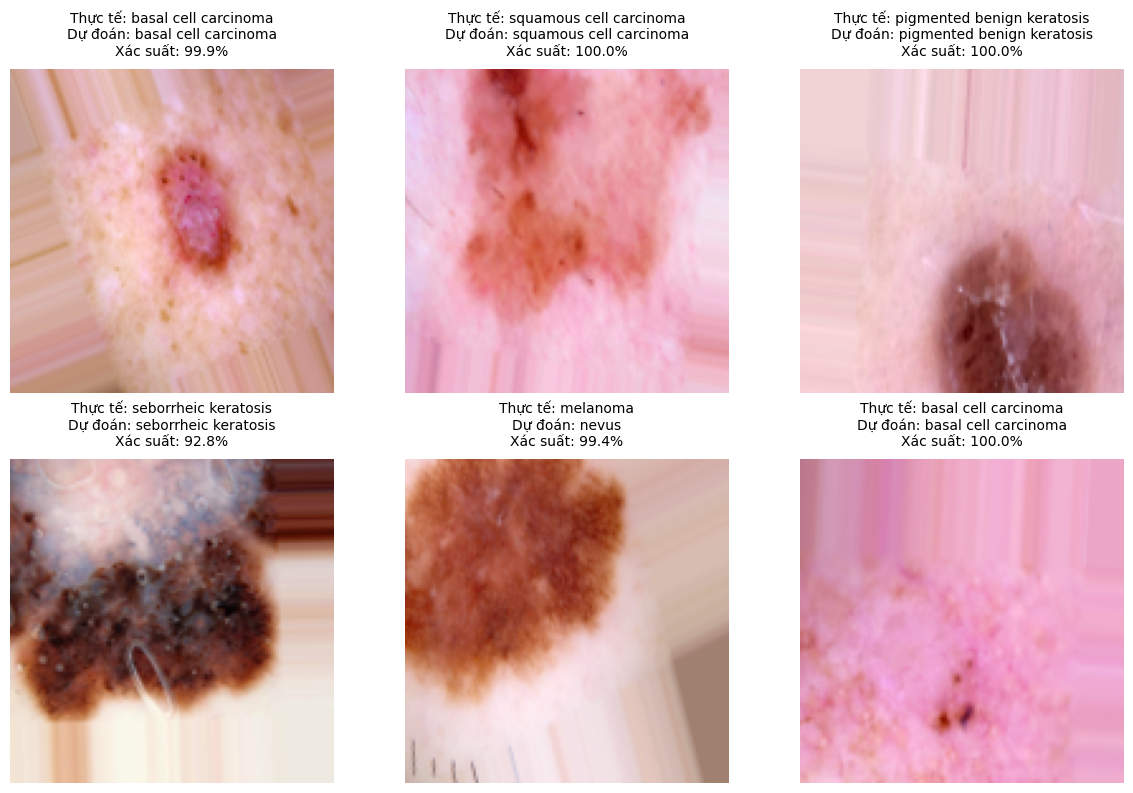

Đã lưu mô hình tại /kaggle/working/skin_cancer_model.h5


In [23]:
def predict_random_samples(model, X_test, y_test, label_map, num_samples=6):
    # Chọn ngẫu nhiên các chỉ số mẫu
    indices = np.random.choice(X_test.shape[0], num_samples, replace=False)
    X_samples = X_test[indices]
    y_samples = y_test[indices]
    
    # Dự đoán
    y_pred = model.predict(X_samples)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_samples, axis=1)
    
    # Tạo lưới hiển thị
    rows = (num_samples + 2) // 3  # Số hàng (3 cột)
    plt.figure(figsize=(12, 4 * rows))
    
    for i in range(num_samples):
        plt.subplot(rows, 3, i + 1)
        img = array_to_img(X_samples[i])
        plt.imshow(img)
        plt.axis('off')
        
        # Lấy nhãn và xác suất
        true_label = label_map[y_true_classes[i]]
        pred_label = label_map[y_pred_classes[i]]
        pred_prob = y_pred[i][y_pred_classes[i]] * 100  # Xác suất lớp dự đoán
        
        # Hiển thị tiêu đề
        title = f"Thực tế: {true_label}\nDự đoán: {pred_label}\nXác suất: {pred_prob:.1f}%"
        plt.title(title, fontsize=10, pad=10)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/random_sample_predictions.png')
    plt.show()

# Chạy hàm với mô hình và dữ liệu
predict_random_samples(model, X_test, y_test, label_map, num_samples=6)

model.save('/kaggle/working/skin_cancer_model.h5')
print("Đã lưu mô hình tại /kaggle/working/skin_cancer_model.h5")